In [4]:
import numpy as np
import pandas as pd

import FinanceDataReader as fdr
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 1. 데이터 로드

* Date: 거래일자 (인덱스로 들어감)
* Open: 시가 (해당 거래일 장 시작가)
* High: 고가 (해당 거래일 중 가장 높은 가격)
* Low: 저가 (해당 거래일 중 가장 낮은 가격)
* Close: 종가 (해당 거래일 장 마감가)
* Volume: 거래량 (해당 거래일 동안 거래된 주식 수량)
* Change: 전일 대비 종가 수익률 (Return, 비율 단위 — 예: -0.003010 → -0.301%)
* Adj Close: 조정 종가 (Adjusted Close) → 배당, 액면분할(split) 등을 반영해 보정된 종가 (장기적인 수익률 계산이나 백테스트에서는 Adj Close를 쓰는 게 안전)

In [5]:
samsung = fdr.DataReader('005930')
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-06-20,26860,26960,26520,26580,356359,NaN
2013-06-21,25880,26660,25800,26500,553556,-0.003010
2013-06-24,27000,27000,26259,26260,316958,-0.009057
2013-06-25,26020,26360,25760,25940,415499,-0.012186
2013-06-26,26020,26100,24900,25220,635024,-0.027756


In [6]:
apple = fdr.DataReader('AAPL')
apple.head()

,Open,High,Low,Close,Volume,Adj Close
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600,0.098485
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800,0.093347
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000,0.086495
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600,0.088636
1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600,0.091206


## 2. 전처리

1) 열 삭제 → 수정 종가(Adj Close)
2) 데이터 분할
3) 데이터셋 생성

In [7]:
del apple['Adj Close']

apple.head()

,Open,High,Low,Close,Volume
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600


In [8]:
train = apple[apple.index.year<=2023] # 훈련 데이터: 옛날 ~ 2023년
test = apple[apple.index.year>2023] # 시험 데이터: 2024년 ~ 현재

print('훈련 데이터:', train.shape)
print('시험 데이터:', test.shape)

훈련 데이터: (10853, 5)
시험 데이터: (420, 5)


In [9]:
def create_dataset(data):
    dataset_x = []
    dataset_y = []
    for i in range(len(data) - 1):
        x = data.iloc[i].values # i 번째 행의 모든 열
        y = data.iloc[i + 1, 3] # i + 1 번째 행의 Close 열
        dataset_x.append(x)
        dataset_y.append(y)
    return dataset_x, dataset_y

In [10]:
train_x, train_y = create_dataset(train)
test_x, test_y = create_dataset(test)

print('문제집:', train_x[0])
print('정답지:', train_y[0])

문제집: [1.28347993e-01 1.28905997e-01 1.28347993e-01 1.28347993e-01
 4.69033600e+08]
정답지: 0.12165199965238571


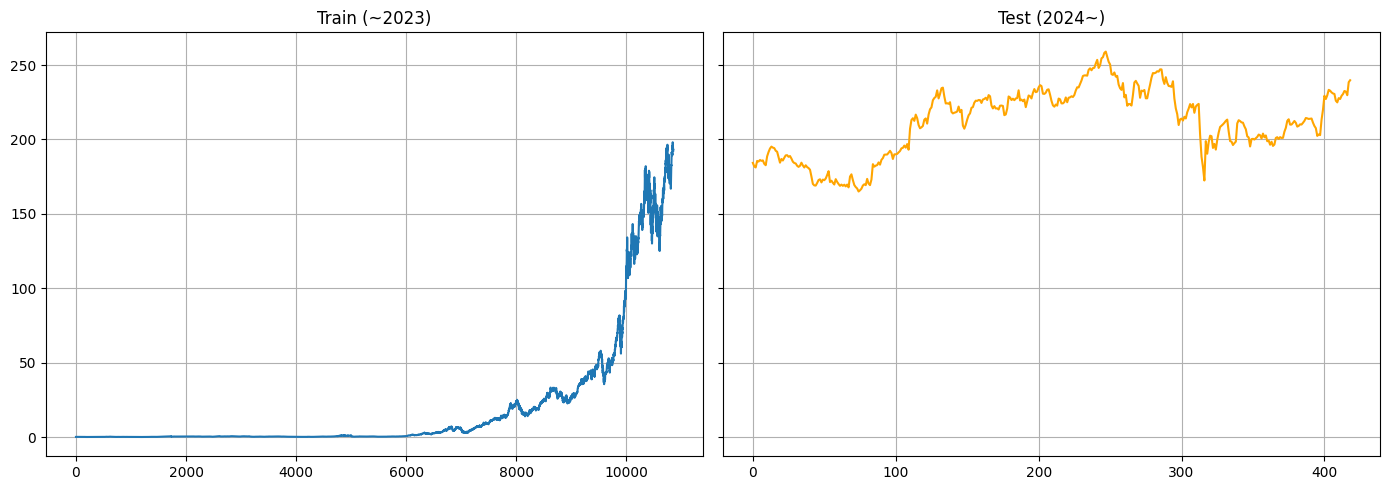

In [11]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].plot(train_y)
axes[0].set_title("Train (~2023)")
axes[0].grid(True)

axes[1].plot(test_y, color="orange")
axes[1].set_title("Test (2024~)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 3. 모델링 및 평가

1) 베이스라인 → LinearRegressor, RandomForestRegressor
2) 시계열 구조 반영 → XGBoost, LightGBM
3) 딥러닝 계열 → LSTM / GRU, 1D CNN, Transformer

In [12]:
def eval_regression(y_true, y_pred, label=''):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'[{label}] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}')
    return rmse, mae, r2

### 1) Baseline

* 오늘의 OHLCV -> 내일의 Close

In [13]:
# Linear Regression -> 선형 계열은 표준화 필요
lin_pipe  = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', LinearRegression())
])
lin_pipe .fit(train_x, train_y)
pred_lin  = lin_pipe .predict(test_x)
eval_regression(test_y, pred_lin, label='Linear')

[Linear] RMSE: 3.7899 | MAE: 2.5336 | R2: 0.9721


(np.float64(3.789858927564284), 2.5335577931478093, 0.972059302631499)

In [ ]:
# RidgeCV -> 알파 자동 튜닝
ridge_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', RidgeCV(alphas=np.logspace(-4, 4, 25)))
])
ridge_pipe.fit(train_x, train_y)
pred_ridge = ridge_pipe.predict(test_x)
eval_regression(test_y, pred_ridge, label='RidgeCV')

[RidgeCV] RMSE: 3.7782 | MAE: 2.5324 | R2: 0.9722


(np.float64(3.7782355902812466), 2.5323769220100796, 0.9722304256926311)

In [ ]:
# Random Forest -> 트리 계열은 표준화 불필요
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_x, train_y)
pred_rf = rf.predict(test_x)
eval_regression(test_y, pred_rf, label='RandomForest')

[RandomForest] RMSE: 25.6156 | MAE: 19.7926 | R2: -0.2764


(np.float64(25.615594549608126), 19.792568439412662, -0.2764389085850507)

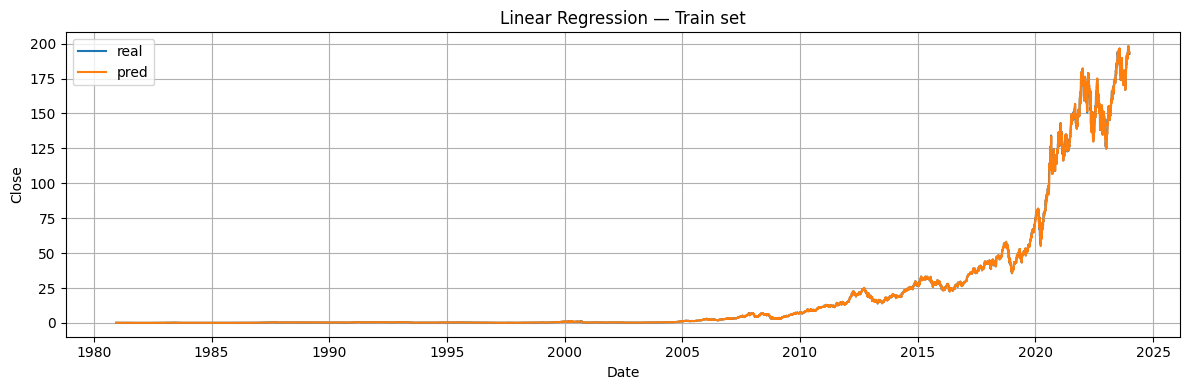

In [17]:
# 시각화
pred_lin_tr = lin_pipe.predict(train_x)
try:
    x_axis_tr = train.index[1:]
    x_label_tr = "Date"
except NameError:
    x_axis_tr = np.arange(len(train_y))
    x_label_tr = "Index"

plt.figure(figsize=(12,4))
plt.plot(x_axis_tr, train_y,     label='real')
plt.plot(x_axis_tr, pred_lin_tr, label='pred')
plt.title('Linear Regression — Train set')
plt.xlabel(x_label_tr); plt.ylabel('Close')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [16]:
eval_regression(test_y, pred_lin, label='Linear')
eval_regression(test_y, pred_ridge, label='RidgeCV')
eval_regression(test_y, pred_rf, label='RandomForest')

[Linear] RMSE: 3.7899 | MAE: 2.5336 | R2: 0.9721
[RidgeCV] RMSE: 3.7782 | MAE: 2.5324 | R2: 0.9722
[RandomForest] RMSE: 25.6156 | MAE: 19.7926 | R2: -0.2764


(np.float64(25.615594549608126), 19.792568439412662, -0.2764389085850507)

### 2) 시계열 구조 반영

* 래그(lag) 피처: 과거 며칠 전 값을 현재 입력에 포함
* 이동통계(rolling statistics) 피처: 일정 기간의 평균이나 표준편차를 입력에 포함
* 부스팅(boosting) 계열: 여러 개의 약한 트리를 순차적으로 학습시켜 강력한 예측력을 만들어냄

In [ ]:
def make_ts_features(df: pd.DataFrame, close_col='Colse', vol_col='Volume'):
    df = df.copy()

    # 수익률(로그/단순) & 래그
    df['ret1'] = df[close_col].pct_change()

In [ ]:
def make_ts_features(df: pd.DataFrame, close_col="Close", vol_col="Volume"):
    """OHLCV에서 시계열 피처 생성 (룩어헤드 방지)"""
    df = df.copy()

    # 수익률(로그/단순) & 래그
    df["ret1"] = df[close_col].pct_change()
    for l in [1,2,3,5,10,20]:
        df[f"close_lag{l}"] = df[close_col].shift(l)
        df[f"ret_lag{l}"]   = df["ret1"].shift(l)

    # 이동평균/이동표준편차/볼륨 변화
    for w in [3,5,10,20]:
        df[f"ma_{w}"]  = df[close_col].rolling(w).mean()
        df[f"std_{w}"] = df[close_col].rolling(w).std()
        df[f"vol_ma_{w}"]  = df[vol_col].rolling(w).mean()
    df["vol_chg1"] = df[vol_col].pct_change()

    # 타깃: 내일 Close
    df["y_next_close"] = df[close_col].shift(-1)

    # 모델 입력 컬럼
    base_cols = ["Open","High","Low","Close","Volume"]
    feat_cols = [c for c in df.columns if c not in base_cols + ["y_next_close","ret1"]]
    feat_cols = base_cols + feat_cols  # base + engineered

    # 정리
    df = df[feat_cols + ["y_next_close"]].dropna()
    return df, feat_cols

# 원본 apple로 피처 생성
fe_df, feat_cols = make_ts_features(apple)    # apple은 이미 가지고 계신 DF
train_fe = fe_df[fe_df.index.year <= 2023]
test_fe  = fe_df[fe_df.index.year >  2023]

X_tr, y_tr = train_fe[feat_cols], train_fe["y_next_close"]
X_te, y_te = test_fe[feat_cols],  test_fe["y_next_close"]

# ---- 스케일 민감한 모델에 대비해 표준화 파이프라인 구성 ----
from sklearn.compose import ColumnTransformer
num_features = feat_cols
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)],
    remainder="drop"
)

# 1) Ridge + 시계열 피처
ridge_ts = Pipeline([
    ("prep", preprocess),
    ("model", RidgeCV(alphas=np.logspace(-4, 4, 25)))
])
ridge_ts.fit(X_tr, y_tr)
pred_ridge_ts = ridge_ts.predict(X_te)
eval_regression(y_te, pred_ridge_ts, label="RidgeCV + TS features")

# 2) RandomForest + 시계열 피처
rf_ts = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_ts.fit(X_tr, y_tr)
pred_rf_ts = rf_ts.predict(X_te)
eval_regression(y_te, pred_rf_ts, label="RandomForest + TS features")

# 3) XGBoost / LightGBM (설치되어 있으면 사용)
xgb_pred = None
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=1200,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)
    xgb_pred = xgb.predict(X_te)
    eval_regression(y_te, xgb_pred, label="XGBoost + TS features")
except Exception as e:
    print("[XGBoost] 사용 불가:", e)

lgbm_pred = None
try:
    from lightgbm import LGBMRegressor
    lgbm = LGBMRegressor(
        n_estimators=1500,
        max_depth=-1,
        learning_rate=0.02,
        subsample=0.9,
        colsample_bytree=0.9,
        num_leaves=63,
        random_state=42,
        n_jobs=-1
    )
    lgbm.fit(X_tr, y_tr)
    lgbm_pred = lgbm.predict(X_te)
    eval_regression(y_te, lgbm_pred, label="LightGBM + TS features")
except Exception as e:
    print("[LightGBM] 사용 불가:", e)

# =========================================================
# (옵션) 예측 시각화
# =========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_te.values, label="Actual (Test)")
plt.plot(pred_ridge_ts, label="Ridge+TS")
plt.plot(pred_rf_ts, label="RF+TS")
if xgb_pred is not None:  plt.plot(xgb_pred, label="XGB+TS")
if lgbm_pred is not None: plt.plot(lgbm_pred, label="LGBM+TS")
plt.title("Next-day Close: Test Period")
plt.xlabel("Time (index order)")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()